Putting the sequential feeding of data into the RNN part of the RNN module (how else are we going to be able to train our thalamus layer??). Implements strucutre of RNN then linear layer then RNN. DOES NOT RUN BUT I AM TIRED AND AM GIVING UP

In [1]:
from scipy.io import loadmat
import numpy as np
import torch 


In [2]:
monkey_data = loadmat('monkey_data.mat') 
visual_data = monkey_data['inp'][0]
muscle_data = monkey_data['targ'][0]

In [3]:
test = np.zeros((502, 2))
for i, data in enumerate(visual_data):
    test[i] = data.shape

print(test[:,1].max())

341.0


In [4]:
batch_size = visual_data.shape[0] # N, 502
trial_len = int(test[:,1].max()) # visual_data[0].shape[1] # T, 298 
in_dim = visual_data[0].shape[0] # L, 21
out_dim = muscle_data[0].shape[0] # O, 50

hid_dim = 100
num_layers = 3

In [5]:
new_visual_data = np.zeros((batch_size, trial_len, in_dim))

for i, data in enumerate(visual_data):
    new_visual_data[i, 0:visual_data[i].shape[1], :] = visual_data[i].transpose()
print(new_visual_data.shape)

(502, 341, 21)


In [6]:
import math
from sklearn.model_selection import train_test_split
from sklearn.utils import gen_batches
# np.random.seed()

 # shuffling was somehow change 
train_idx, test_idx = train_test_split(
     range(batch_size), 
     test_size=0.2, 
     shuffle=True )

train_input = np.zeros((int(batch_size * .8), trial_len, in_dim))
train_output = np.zeros((int(batch_size * .8), trial_len, out_dim))
test_input = np.zeros((int(np.ceil(batch_size * .2)), trial_len, in_dim))
test_output = np.zeros((int(np.ceil(batch_size * .2)), trial_len, out_dim))
train_ind = 0
test_ind = 0
for i, data in enumerate(visual_data):
     if i in train_idx:
       # train_input[train_ind, 0:visual_data[i].shape[1], :] = visual_data[i].transpose()
       train_input[train_ind, -visual_data[i].shape[1]:, :] = visual_data[i].transpose()
       train_output[train_ind, -visual_data[i].shape[1]:, :] = muscle_data[i].transpose()
       train_ind += 1
     else:
        test_input[test_ind, -visual_data[i].shape[1]:, :] = visual_data[i].transpose()
        test_output[test_ind, -visual_data[i].shape[1]:, :] = muscle_data[i].transpose()
        test_ind += 1

# for use in weighted loss
muscle_length_vec = torch.tensor([9.8, 10.8, 13.7, 6.8, 7.6, 8.7, 7.4, 16.2, 14.4, 13.8, 13.8, 25.4, 23.2, 27.9, 9.3, 13.4, 11.4, 11.4, 2.7, 3.3, 11.6, 13.2, 8.6, 17.3, 8.1, 5.9, 6.2, 6.3, 5.1, 6.4, 4.9, 2.8, 5.2, 7.4, 7.5, 8.4, 7.5, 8.0, 8.4, 7.5, 6.5, 6.3, 7.2, 7.0, 6.8, 5.9, 5.4, 6.8, 5.5, 7.1])
muscle_weight_vec = (1/muscle_length_vec) * (2.5*torch.min(muscle_length_vec))





- ReTanh activation function --> yes
- rate regularization: 1e-1 --> yes
- weight regularization: 1e-5 --> yes
- intermodule sparsity: 0.1 --> yes
- Hessian free optimization --> yes
- birdirectional --> no

In [7]:
def hardcore_loss(output, target, model_params):
    firing_reg = 1e-1
    weight_reg = 1e-5
    weight_sum = torch.zeros((1))
    for name, param in model_params: 
        if "weight" in name:
            weight_sum += torch.sum(param **  2)

    loss = torch.sum((output - target)**2) + firing_reg * torch.sum(output ** 2) + weight_reg * weight_sum
    return loss

In [8]:
def hardcore_loss_weighted(output, target, model_params):
    firing_reg = 1e-1
    weight_reg = 1e-5
    weight_sum = torch.zeros((1))
    for name, param in model_params: 
        if "weight" in name:
            weight_sum += torch.sum(param **  2)
    
    # not entirely sure if this line is right
    
    target_diff_sum = torch.sum((muscle_weight_vec*(output - target))**2)

    loss = target_diff_sum
    return loss

In [9]:
from torch import nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F

from mrnn import MilliesRNN
from hessianfree import HessianFree

learning_rate = 0.001
hessian = False
hardcore = True
intermodule_connections_removed = .9


model = MilliesRNN(in_dim, hid_dim, out_dim, True)
module1 = model.h2o
prune.random_unstructured(module1, name="weight", amount=intermodule_connections_removed)
module2 = model.thal
prune.random_unstructured(module2, name="weight", amount=intermodule_connections_removed)
model.train()
batches = []
shuffed = np.arange(0,401)
np.random.shuffle(shuffed)
for i in range(5):
    idx = shuffed[int((train_input.shape[0]/5)*i):int((train_input.shape[0]/5)*(i+1))]
    batches.append(idx)
outputs = model(torch.from_numpy(train_input[batches[0]]).to(torch.float32))   
loss = hardcore_loss(outputs, torch.from_numpy(train_output[batches[0]]).to(torch.float32), model.named_parameters())
print(loss)

loss_weighted = hardcore_loss_weighted(outputs, torch.from_numpy(train_output[batches[0]]).to(torch.float32), model.named_parameters())
print(loss_weighted)


tensor([35175.1523], grad_fn=<AddBackward0>)
tensor(30965.3770, grad_fn=<SumBackward0>)


In [11]:
from torch import nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F

from mrnn import MilliesRNN
from hessianfree import HessianFree

learning_rate = 0.001
hessian = False
hardcore = True
intermodule_connections_removed = .9


model = MilliesRNN(in_dim, hid_dim, out_dim, True)
module1 = model.h2o
prune.random_unstructured(module1, name="weight", amount=intermodule_connections_removed)
module2 = model.thal
prune.random_unstructured(module2, name="weight", amount=intermodule_connections_removed)

if hardcore:
    criterion1 = hardcore_loss
    criterion2 = hardcore_loss_weighted
else:
    criterion1 = nn.MSELoss() 

if hessian:
    optimizer = HessianFree(model.parameters(), use_gnm=True, verbose=True)
else:
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 20
print_interval = 100
loss_error = []

preds = np.zeros((int(batch_size * .8), trial_len, out_dim))

model.train()
for epoch in range(num_epochs):
    batches = []
    shuffed = np.arange(0,401)
    np.random.shuffle(shuffed)
    for i in range(5):
        idx = shuffed[int((train_input.shape[0]/5)*i):int((train_input.shape[0]/5)*(i+1))]
        
        batches.append(idx)
    
    for j, batch in enumerate(batches):
        
        optimizer.zero_grad()

        outputs = model(torch.from_numpy(train_input[batch]).to(torch.float32))   

        if hardcore:
            if epoch < 3*num_epochs/4:
                loss = criterion1(outputs, torch.from_numpy(train_output[batch]).to(torch.float32), model.named_parameters())
            else:
                loss = criterion2(outputs, torch.from_numpy(train_output[batch]).to(torch.float32), model.named_parameters())
        else:
            loss = criterion1(outputs, torch.from_numpy(train_output[batch]).to(torch.float32))
        
            
        nn.utils.clip_grad_norm_(model.parameters(), 1)

        def closure():
            gen_output = model(torch.from_numpy(train_input[batch]).to(torch.float32))
            loss = criterion1(gen_output, torch.from_numpy(train_output[batch]).to(torch.float32), model.named_parameters())
            loss.backward(create_graph=True)
            return loss, gen_output
        
        if hessian:
            optimizer.step(closure, M_inv=None)
        else: # gradient descent
            loss.backward()
            optimizer.step()

        loss_error.append(loss.item())
        # if i == 0 or (i + 1) % print_interval == 0:
        print(
            f"Epoch [{epoch + 1}/{num_epochs}], "
            f"Step [{j + 1}/{len(train_output)}], "
            f"Loss: {loss.item():.4f}"
        )
        



/Users/sophi/anaconda3/envs/cap/lib/python3.12/site-packages/torch/autograd/__init__.py:251: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at /Users/runner/miniforge3/conda-bld/libtorch_1711322764797/work/torch/csrc/autograd/engine.cpp:1176.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


KeyboardInterrupt: 

Text(0, 0.5, 'loss')

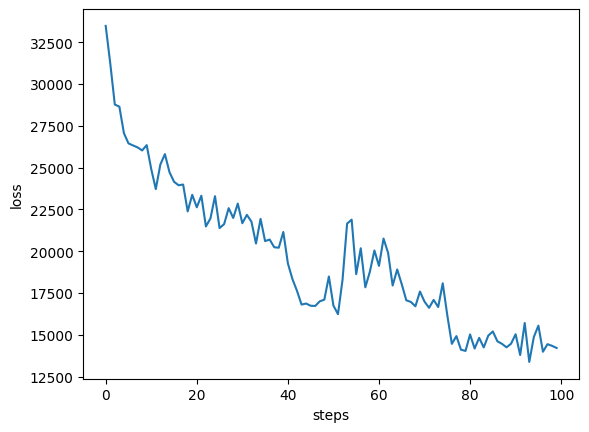

In [ ]:
import matplotlib.pyplot as plt

plt.plot(loss_error)
plt.xlabel("steps")
plt.ylabel("loss")

In [ ]:
# gets test loss using both criterion

preds = torch.empty(batch_size, trial_len, out_dim)

num_correct = 0
num_samples = len(test_input)

model.eval()
loss = 0
with torch.no_grad():
    out = model(torch.from_numpy(test_input).to(torch.float32))
    loss1 = criterion1(out, torch.from_numpy(test_output).to(torch.float32), model.named_parameters())
    loss2 = criterion2(out, torch.from_numpy(test_output).to(torch.float32), model.named_parameters())

print(f"Average test loss (hardcore): {loss1 / num_samples}")
print(f"Average test loss (weighted): {loss2 / num_samples}")

Average test loss (hardcore): tensor([213.0086])
Average test loss (weighted): 187.6349334716797


In [ ]:
import pickle 

with torch.no_grad():
    out = model(torch.from_numpy(new_visual_data).to(torch.float32))

with open('test_outputs.pickle', 'wb') as handle:
    pickle.dump(out, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
n=3
plt.plot(np.average(np.array(loss_error).reshape(-1, n), axis=1))
plt.xlabel("steps")
plt.ylabel("mse loss")

ValueError: cannot reshape array of size 100 into shape (3)

In [ ]:
    """for i, (input, output) in enumerate(train_dataset): # 80% of 502 different examples

        gen_output, hn = model(input)        

        loss = criterion(gen_output, output)
        nn.utils.clip_grad_norm_(model.parameters(), 1)
        def closure():
            gen_output, _ = model(input)
            loss = criterion(gen_output, output)
            loss.backward(create_graph=True)
            return loss, gen_output
        optimizer.step(closure, M_inv=None)
        # add regularization loss with rate and weights here??
        # rate by taking L2 with matrix of zeroes
        loss_error.append(loss.item())
        
        if i == 0 or (i + 1) % print_interval == 0:
            print(
                f"Epoch [{epoch + 1}/{num_epochs}], "
                f"Step [{i + 1}/{len(train_dataset)}], "
                f"Loss: {loss.item():.4f}"
            )"""

In [ ]:
model2 = MilliesRNN(in_dim, hid_dim, out_dim)

module = model2.